# Objekt detektieren und vermessen
Nachfolgend finden Sie Codebeispiel zur Verarbeitung eines Bildes paralle zur Kameraebene. Der Abstand zur Kamera ist bekannt mit ca 31cm. Folgende Schritte sind notwendig, um das Objekt (Quadrat) zu erkennen und zu vermessen:
- Graustufenumwandlung und Ränder abschneiden
- Kontrast erhöhen
- Kanten detektieren bspw. mit Canny
- Konturen finden
- Minimales Rechteck um das Objekt bestimmen
- Grafik nach bestimmtem Winkel des minimalen Rechtecks rotieren --> Ausrichtung X-Y-Achsen
- Variante 1: Erneut Kanten detektieren, Kontueren finden und Quadrat extrahieren
- Variante 2: Abmessungen des Quadrats aus Punkten und Winkel direkt ausrechnen
- Punkte des Quadrats bestimmen und mit Hilfe der Kameramatrix in real berechnen

[[498 228]
 [581 119]
 [692 203]
 [608 313]]


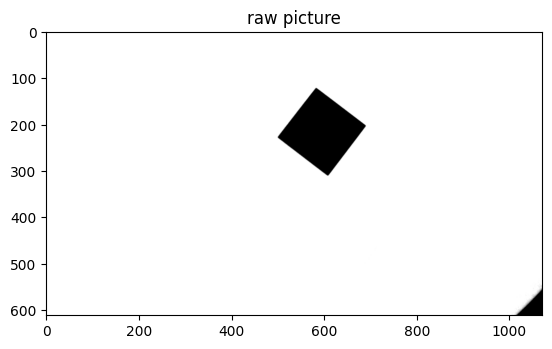

(5.816351267481955, 5.81450677110429)
[[460 130]
 [597 130]
 [597 266]
 [460 266]]


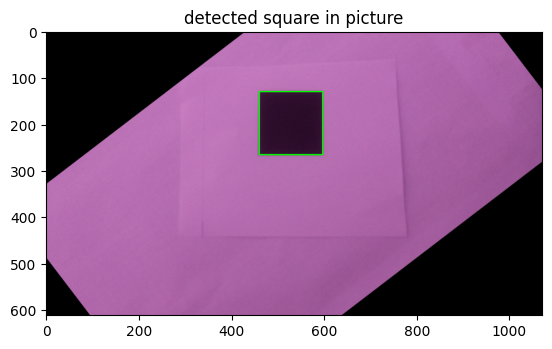

(4.107423317757875, 4.07614907665043)


In [ ]:
import imutils
import cv2
from matplotlib import pyplot as plt
import numpy as np
# camera matrix
cammat= np.array([
    [1.01097775e+03, 0.00000000e+00, 6.60855845e+02],
    [0.00000000e+00, 1.01758321e+03, 2.92871361e+02],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
# distortion coefficients
distcoeff= np.array([[ 2.24482447e-01, -5.54414861e-01, -4.00655540e-03,  2.69779932e-04, 4.26903323e-01]])
# image dimensions
h = 720
w = 1280
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cammat, distcoeff, (w,h), 1, (w,h))

# function to calculate a point from distance
def realsize(width, height, distance):
    fx=newcameramtx[0][0]
    fy=newcameramtx[1][1]
    Xc=(width/fx)*distance
    Yc=(height/fy)*distance
    return (Xc,Yc)
    

# read the source image
img = cv2.imread('testimg.png')
# crop the image
x, y = 100,50
h,w = img.shape[:2]
w = w-2*x
h = h-2*y
img = img[y:y+h, x:x+w]
# add contrast on grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = np.clip(((gray-64.0)*5.0)+64.0,0,255)
gray = gray.astype(np.uint8)
# canny edge detection
edged = cv2.Canny(gray, 35, 125)
# find contours from edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
# use largest contour
c = max(cnts, key = cv2.contourArea)
# compute the bounding box of the of the paper region and return it
box = cv2.minAreaRect(c)
angle = box[-1]

# get box points
box = cv2.boxPoints(box)
# convert to int32
box = np.int0(box)
print(box)
# show gray image
gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
cv2.imwrite('preparedresult.png', gray)
plt.imshow(gray)
plt.title('raw picture')
plt.show()
# print size of the current box 
print(realsize(np.max(box[:,0])-np.min(box[:,0]),np.max(box[:,1])-np.min(box[:,1]),31))
# rotation center
(cX, cY) = (w // 2, h // 2)
# rotate our image around cX,cY of the ORIGINAL image
M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))
cv2.imwrite("rotated.png", rotated)
# again grayscale
gray = cv2.cvtColor(rotated, cv2.COLOR_RGB2GRAY)
gray = np.clip(((gray-64.0)*5.0)+64.0,0,255)
gray = gray.astype(np.uint8)
# canny edge
edged = cv2.Canny(gray, 35, 125)
# find contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key = cv2.contourArea)
# compute the bounding box of the of the paper region and return it
box = cv2.minAreaRect(c)
angle = box[-1]

box = cv2.boxPoints(box)
box = np.int0(box)
print(box)
# draw contour of detected box
cv2.drawContours(rotated, [box], -1, (0, 255, 0), 2)
# show final image
gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
plt.imshow(rotated)
plt.title('detected square in picture')
plt.show()
# print size in rotated image
print(realsize(np.max(box[:,0])-np.min(box[:,0]),np.max(box[:,1])-np.min(box[:,1]),31))
